In [40]:
import numpy as np
#import tensorflow as tf
#import keras
#from keras import backend as K
#from keras.datasets import mnist
#from keras.models import Sequential, Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, Input
#from keras import activations
#import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from math import *
from itertools import chain

import import_ipynb
from Utils import *
from Model import *

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [41]:
sigma_noise = [2, 2]
image_size = (400, 300)
nbr_inliers=300
nbr_outliers=200
size_patch = (8, 8)


In [42]:
#input_dim = size_patch[0]*2+1
model = Weights().to(DEVICE)
model_old_loss = Weights().to(DEVICE)

model_patch = Weights2().to(DEVICE)

### Train model

In [43]:
def loss_func(y1, y2):
    n = len(y1[0])
    s = 0
    for k in range(n):
        print(y1[k][0], y2[k][0])
        s += abs(y1[k][0]-y2[k][0])
    return s

def train_model(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers, loss = 1):
    ((x_test, y_test), (x_train, y_train)) = split_training(generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers, loss = loss))
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-5))
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    print(len(train_dl))
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(xb)
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = sum(loss_fn(model(xb.to(DEVICE)), yb.to(DEVICE)) for xb, yb in valid_dl)
            m_test = sum(len(yb) for xb, yb in valid_dl)

        print("iteration = ", k+1, " ; loss_train = ", loss_train, " ; loss_eval = ", loss_eval.item())
        
        if k == epochs - 1:
            last_weight = model(x_test.to(DEVICE))
            print(last_weight)
            print(y_test)
            print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))
            

def train_model_patch(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers):
    ((x_test, y_test), (x_train, y_train)) = split_training_bis(generate_training_data_patch(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers))
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-6))
    print("data generated")
    
    # Train step
    x_train1, x_train2, x_train3 = x_train
    train_ds = TensorDataset(x_train1, x_train2, x_train3, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    print(len(train_dl))
    
    x_test1, x_test2, x_test3 = x_test
    valid_ds = TensorDataset(x_test1, x_test2, x_test3, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb1, xb2, xb3, yb in train_dl:
            xb1, xb2, xb3, yb = xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float(), yb.to(DEVICE).float()
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model((xb1, xb2, xb3))
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = 0
            m_test = 0
            for xb1, xb2, xb3, yb in valid_dl:
                predict_test = model((xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float()))
                loss_eval += loss_fn(predict_test, yb.to(DEVICE).float())
                m_test += len(yb)

        print("iteration = ", k+1, " ; loss_train = ", loss_train, " ; loss_eval = ", loss_eval.item())
        
        if k == epochs - 1:
            last_weight = model((x_test1.to(DEVICE).float(), x_test2.to(DEVICE).float(), x_test3.to(DEVICE).float()))
            print(last_weight)
            print(y_test)
            print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))




In [44]:

train_model(model, image_size, sigma_noise, 30, 529, 100, 100, nbr_inliers, nbr_outliers)
train_model(model_old_loss, image_size, sigma_noise, 30, 529, 100, 100, nbr_inliers, nbr_outliers, loss = 0)
train_model_patch(model_patch, image_size, sigma_noise, 30, 529, 100, 100, nbr_inliers, nbr_outliers)

data generated
143
iteration =  1  ; loss_train =  355.00507378578186  ; loss_eval =  9.349258422851562
iteration =  2  ; loss_train =  338.76170629262924  ; loss_eval =  9.382851600646973
iteration =  3  ; loss_train =  337.50466588139534  ; loss_eval =  9.23510456085205
iteration =  4  ; loss_train =  334.458599075675  ; loss_eval =  9.279936790466309
iteration =  5  ; loss_train =  331.6546429693699  ; loss_eval =  9.405237197875977
iteration =  6  ; loss_train =  333.35048058629036  ; loss_eval =  9.598386764526367
iteration =  7  ; loss_train =  327.62079095840454  ; loss_eval =  9.392875671386719
iteration =  8  ; loss_train =  330.6391562446952  ; loss_eval =  9.2744140625
iteration =  9  ; loss_train =  321.8542483821511  ; loss_eval =  9.526289939880371
iteration =  10  ; loss_train =  320.8820285499096  ; loss_eval =  9.300515174865723
iteration =  11  ; loss_train =  320.44209772348404  ; loss_eval =  9.49420166015625
iteration =  12  ; loss_train =  314.69576148688793  ; lo

### Test weights results

In [45]:
def test_weights_image(model1, model2, model3, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])
    print(n)
    
    for it in range(10):
        print("iteration = ", it)
        i1 = np.random.randint(n)
        scale = 10
        all_features_nn = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        all_features_patch1 = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        all_features_patch2 = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        all_features_patch3 = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        data[0].append(-1)
        data[1].append(-1)
        print(len(data[0]))
        p1 = (data[0][i1], data[1][i1])
        weights_ref = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        weights_ref_old = [[-1]*(image[0]//scale) for _ in range(image[1]//scale)]
        for y in range(0, image[1], scale):
            for x in range(0, image[0], scale):
                p2 = (x/image[0], y/image[0])
                data[0][-1] = float(x)/image[0]
                data[1][-1] = float(y)/image[1]
                #print(p1)
                #print(p2)
                feature_nn = compute_features_k(data, i1, n)
                all_features_nn[(image[1]-y-1)//scale][x//scale] = feature_nn
                feature1, feature2, feature3=compute_features_patch(data, i1, n, image)
                all_features_patch1[(image[1]-y-1)//scale][x//scale] = feature1
                all_features_patch2[(image[1]-y-1)//scale][x//scale] = feature2
                all_features_patch3[(image[1]-y-1)//scale][x//scale] = feature3

                line = compute_line_from_points(p1, p2, image)
                area_old = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref[(image[1]-y-1)//scale][x//scale] = area
                weights_ref_old[(image[1]-y-1)//scale][x//scale] = area_old
        
        del(data[0][n])
        del(data[1][n])
        print(len(data[0]))

        all_features_nn = list(chain.from_iterable(all_features_nn))
        all_features_patch1 = list(chain.from_iterable(all_features_patch1))
        all_features_patch2 = list(chain.from_iterable(all_features_patch2))
        all_features_patch3 = list(chain.from_iterable(all_features_patch3))
        
        model1.eval()
        model2.eval()
        model3.eval()
        with torch.no_grad():                
            X_tensor_nn = torch.Tensor(all_features_nn)
            weights1 = model1(X_tensor_nn.to(DEVICE))

            X_tensor_patch1 = torch.Tensor(all_features_patch1)
            X_tensor_patch2 = torch.Tensor(all_features_patch2)
            X_tensor_patch3 = torch.Tensor(all_features_patch3)
            weights2 = model2((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))

            weights3 = model3(X_tensor_nn.to(DEVICE))
 
        plot_first_point(data, line_ref, p1, image)
        plot_image(weights_ref_old, image, scale)
        plot_image(weights3.cpu(), image, scale)
        plot_image(weights_ref, image, scale)
        plot_image(weights1.cpu(), image, scale)
        plot_image(weights2.cpu(), image, scale)

480
iteration =  0
481
480
(30, 40)


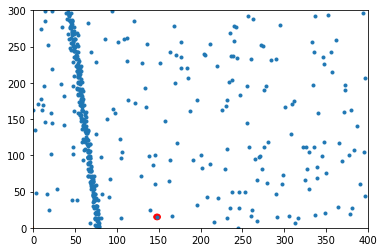

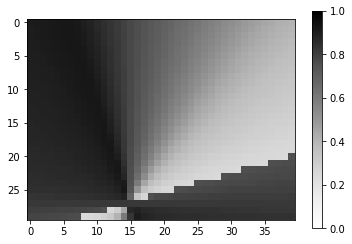

(30, 40)


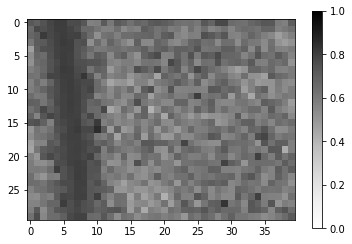

(30, 40)


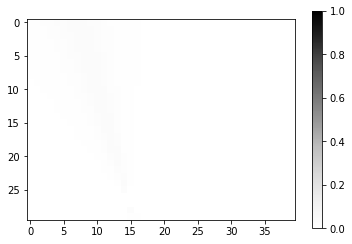

(30, 40)


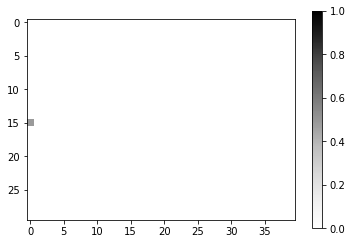

(30, 40)


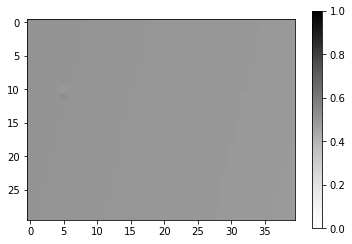

iteration =  1
481
480
(30, 40)


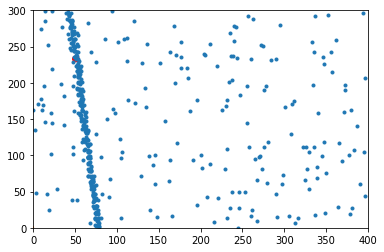

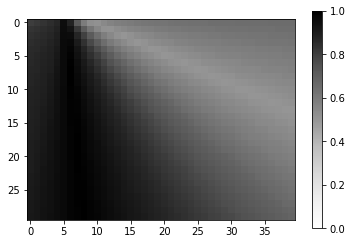

(30, 40)


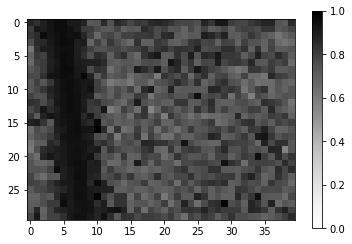

(30, 40)


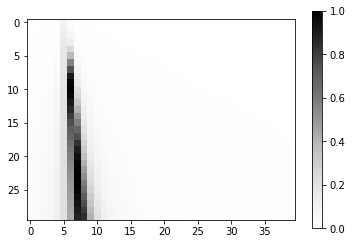

(30, 40)


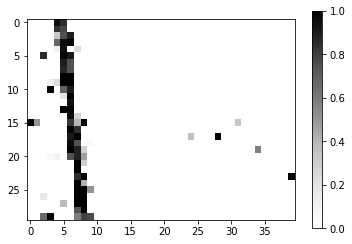

(30, 40)


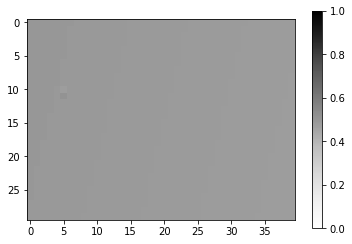

iteration =  2
481
480
(30, 40)


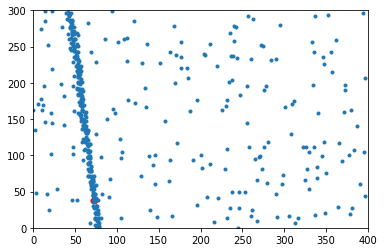

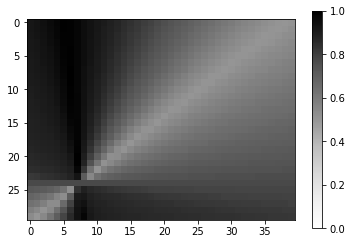

(30, 40)


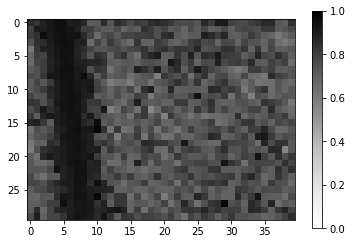

(30, 40)


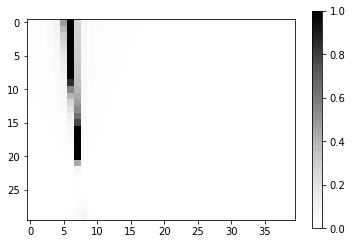

(30, 40)


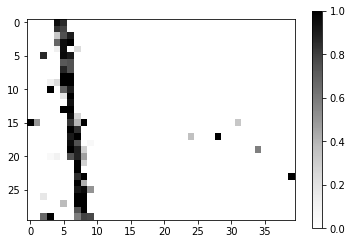

(30, 40)


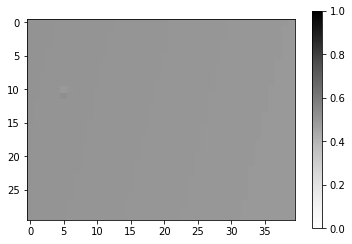

iteration =  3
481
480
(30, 40)


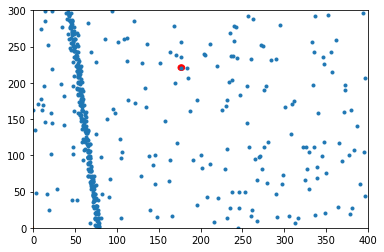

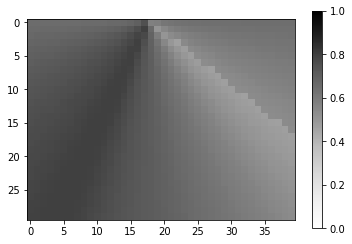

(30, 40)


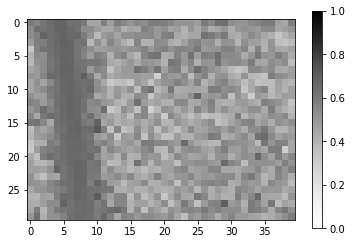

(30, 40)


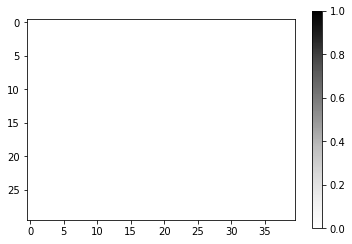

(30, 40)


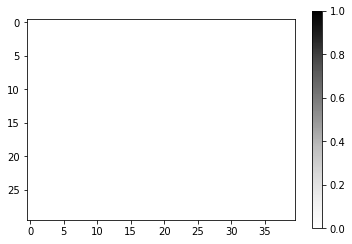

(30, 40)


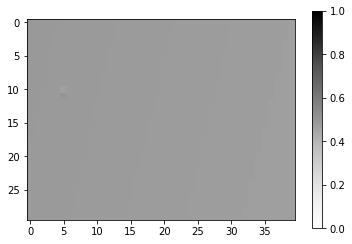

iteration =  4
481
480
(30, 40)


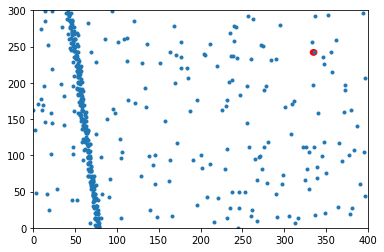

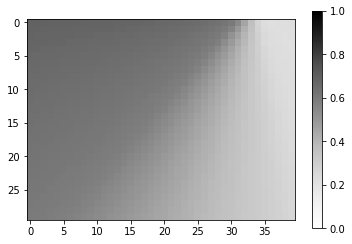

(30, 40)


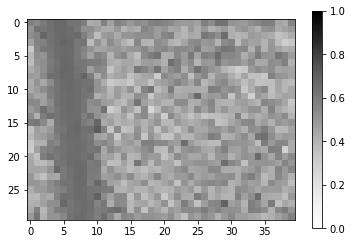

(30, 40)


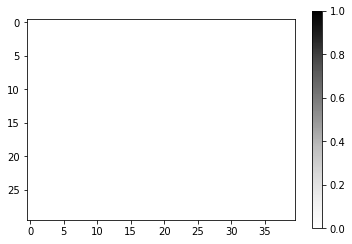

(30, 40)


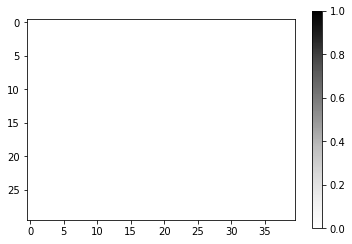

(30, 40)


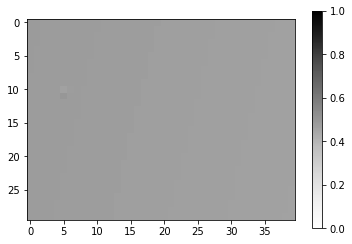

iteration =  5
481
480
(30, 40)


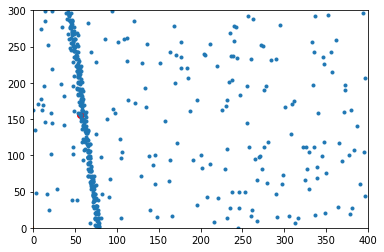

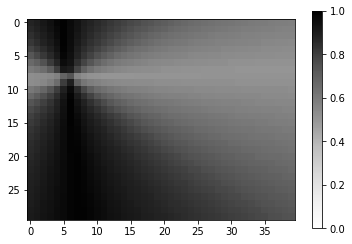

(30, 40)


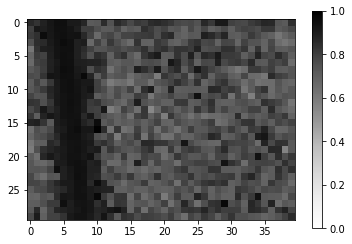

(30, 40)


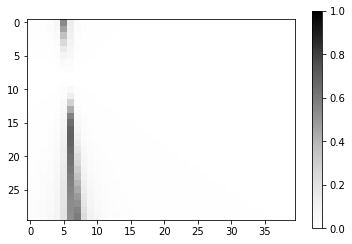

(30, 40)


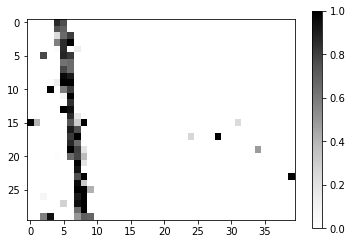

(30, 40)


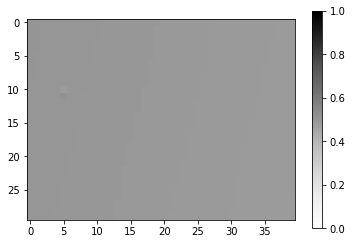

iteration =  6
481
480
(30, 40)


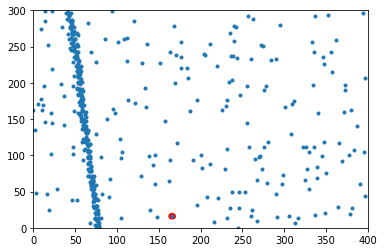

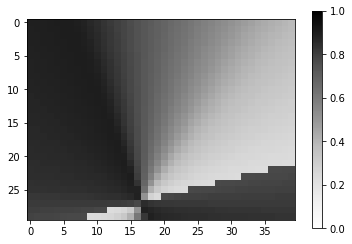

(30, 40)


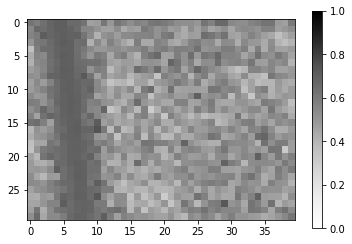

(30, 40)


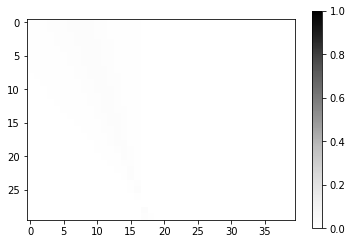

(30, 40)


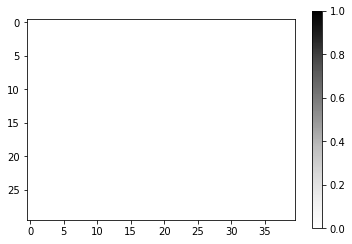

(30, 40)


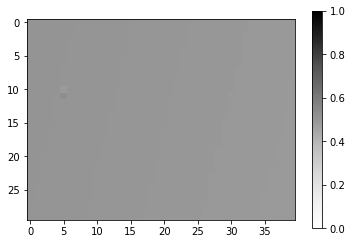

iteration =  7
481
480
(30, 40)


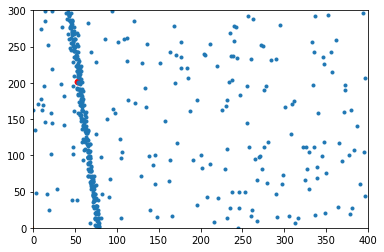

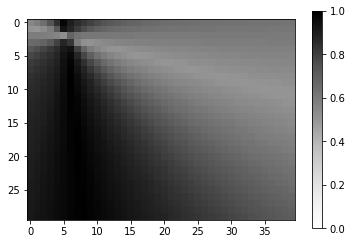

(30, 40)


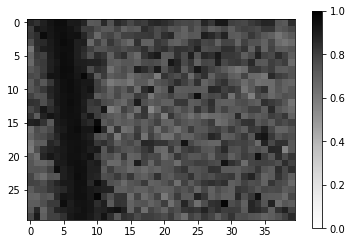

(30, 40)


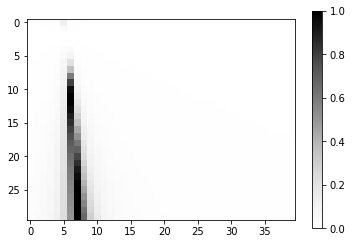

(30, 40)


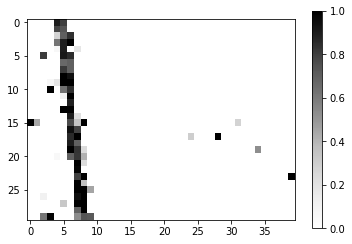

(30, 40)


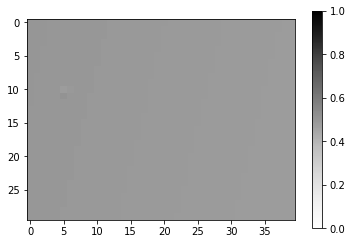

iteration =  8
481
480
(30, 40)


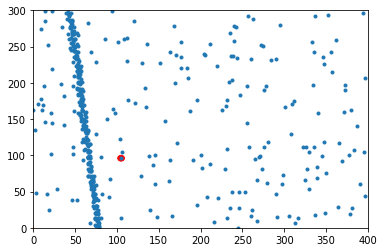

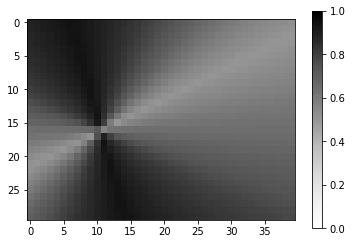

(30, 40)


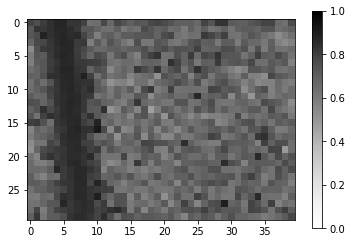

(30, 40)


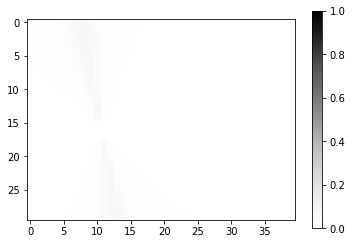

(30, 40)


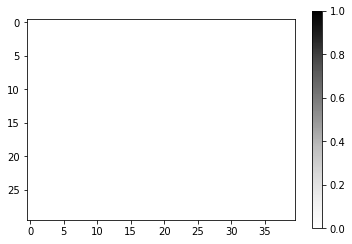

(30, 40)


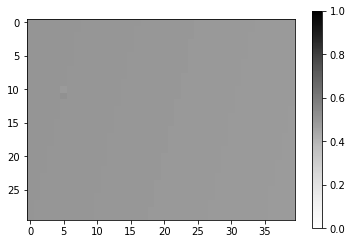

iteration =  9
481
480
(30, 40)


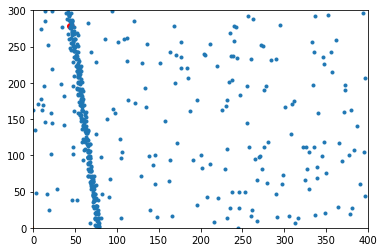

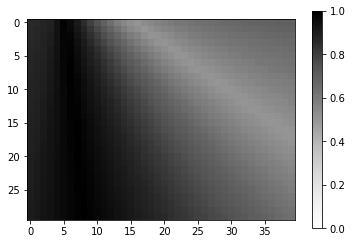

(30, 40)


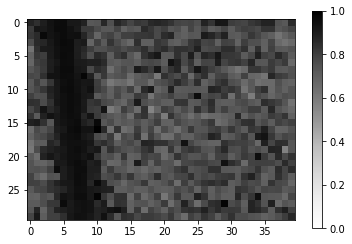

(30, 40)


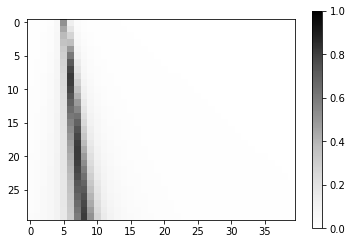

(30, 40)


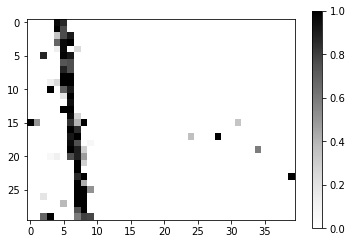

(30, 40)


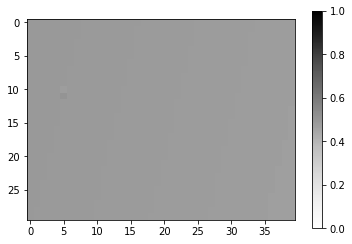

In [46]:
test_weights_image(model, model_patch, model_old_loss, image_size, sigma_noise, nbr_inliers, nbr_outliers)

In [47]:
def test_nn(model, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(10):
        i1 = np.random.randint(n)
        X = []
        coord = []
        weights_ref = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature=compute_features(data, i1, i2)
                X.append(feature)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                #area = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref.append([area])
                
                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():
            X_tensor = torch.Tensor(X)
            weights = model(X_tensor)
        
        #plot_weights(weights, coord, p1, image)
        plot_weights(weights_ref, coord, p1, image, ref=True)
        
def test_nn_compare(model1, model2, model3, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(10):
        i1 = np.random.randint(n)
        X_nn = []
        X_nn_old = []
        X_patch1 = []
        X_patch2 = []
        X_patch3 = []
        coord = []
        weights_ref = []
        weights_ref_old = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature_nn=compute_features_k(data, i1, i2)
                X_nn.append(feature_nn)
                
                feature1, feature2, feature3=compute_features_patch(data, i1, i2, image)
                X_patch1.append(feature1)
                X_patch2.append(feature2)
                X_patch3.append(feature3)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                area_old = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref.append([area])
                weights_ref_old.append([area_old])

                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():                
            X_tensor_nn = torch.Tensor(X_nn)
            weights1 = model1(X_tensor_nn.to(DEVICE))
            
            X_tensor_patch1 = torch.Tensor(X_patch1)
            X_tensor_patch2 = torch.Tensor(X_patch2)
            X_tensor_patch3 = torch.Tensor(X_patch3)
            weights2 = model2((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))
            
            weights3 = model3(X_tensor_nn.to(DEVICE))

        
        plot_weights(weights_ref_old, coord, p1, image)
        plot_weights(weights3, coord, p1, image)
        
        plot_weights(weights_ref, coord, p1, image)
        plot_weights(weights1, coord, p1, image)
        plot_weights(weights2, coord, p1, image)




In [ ]:
test_nn_compare(model, model_patch, model_old_loss, image_size, sigma_noise, nbr_inliers, nbr_outliers)

### Ransac

In [48]:
def get_inliers(data, line, threshold, image):
    a, b = line
    X, Y = data
    Inliers = [[], []]
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        (xb, yb) = x*image[0], y*image[1]
        if abs((a*xb+b) - yb)/sqrt(1+a*a) < threshold:
            Inliers[0].append(x)
            Inliers[1].append(y)
    return Inliers

def get_first_point(method, data, image, densities):
    if method == 0:
        i1 = np.random.randint(len(data[0]))
    elif method == 1:
        n = len(data[0])
        i1 = sample_from_weights(data, densities)
        
    return i1
        

def get_model(model, model_type, data, image, type_loss, type_first_point, line_ref, densities):
    i1 = get_first_point(type_first_point, data, image, densities)
    if line_ref is None:
        weights = compute_weights(model, model_type, data, i1, image)
    else:
        weights = compute_weights_ref(line_ref, image, data, i1, type_loss)
    #print(mean_weights(weights))
    i2 = sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def update_stopping_criterion(k, inliers, proba, it_end):
    if k >= it_end:
        return True
    return False


def ransac(data, threshold, image, proba, type_first_point, type_loss, model_type = None, line_ref=None, model=None, compare=False, it_end=150, n_x=0.05, n_y=0.05):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    densities = get_density_vector(data, image, n_x, n_y)
    while not end:
        line = get_model(model, model_type, data, image, type_loss, type_first_point, line_ref, densities)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

### Uniform Ransac


In [49]:
def get_model_uniform(data, image):
    n = len(data[0])
    i1 = np.random.randint(n)
    i2 = np.random.randint(n)
    while i1 == i2:
        i2 = np.random.randint(n)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def ransac_uniform(data, threshold, image, proba, it_end=150):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model_uniform(data, image)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    return line_max, inliers_max, nbr_inliers

### Compare Ransacs

In [50]:
def compare_uniform(image, sigma, n_inliers, n_outliers, type_loss, model=None, model_type=None,average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = generate_line(image)
        data = generate_data(line, image, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 5
    proba = 0.1
    
    it = 150
    nbr_inliers_sample = [0]*it
    nbr_inliers_uniform = [0]*it
    
    for k in range(average):
        print(k)
        line_predict1, inliers1, nbr_inliers1 = ransac(Datas[k], threshold, image, proba, 0, type_loss, model_type=model_type, line_ref=Lines[k], model=model, compare=True, it_end=it)
        line_predict2, inliers2, nbr_inliers2 = ransac_uniform(Datas[k], threshold, image, proba, it_end=it)
        plot_lines(Datas[k], line_predict1, line_predict2, image)
        
        for j in range(it):
            nbr_inliers_sample[j] += nbr_inliers1[j]
            nbr_inliers_uniform[j] += nbr_inliers2[j]
    
    for j in range(it):
        nbr_inliers_sample[j] /=average
        nbr_inliers_uniform[j] /= average
        
    fig, ax = plt.subplots()
    ax.plot(nbr_inliers_sample, c='g')
    ax.plot(nbr_inliers_uniform, c='r')
    fig.show()
    
    print("done")

def compare_all_ransac(image, sigma, models, n_inliers, n_outliers, average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = generate_line(image)
        data = generate_data(line, image, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 5
    proba = 0.1
    
    it = 150
    n_types = len(models)
    nbr_inliers_all = [[0]*it for _ in range(n_types+1)]
    colors = ['black', 'green', 'red', 'yellow', 'orange', 'blue']
    
    for k in range(average):
        print(k)
        fig, ax = plt.subplots()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        data = Datas[k]
        plot_data(data, ax)
        for j in range(n_types):
            (model, model_type, type_loss, first_point, ref) = models[j]
            if ref:
                line_ref=Lines[k]
            else:
                line_ref=None
            line_predict, inliers, nbr_inliers = ransac(data, threshold, image, proba, first_point, type_loss, model_type = model_type, line_ref=line_ref, model=model, compare=True, it_end=it)
            plot_line(line_predict, image, ax, c=colors[j%len(colors)])

            for i in range(it):
                nbr_inliers_all[j][i] += nbr_inliers[i]
        
        line_predict_uni, inliers_unie, nbr_inliers_uni = ransac_uniform(data, threshold, image, proba, it_end=it)
        plot_line(line_predict_uni, image, ax, c=colors[n_types%len(colors)])
        for i in range(it):
            nbr_inliers_all[-1][i] += nbr_inliers_uni[i]

    
    for j in range(n_types+1):
        for i in range(it):
            nbr_inliers_all[j][i] /=average
        
    fig2, ax2 = plt.subplots()
    for j in range(n_types+1):
        ax2.plot(nbr_inliers_all[j], c=colors[j%len(colors)])
    fig2.show()
    
    print("done")


0
1
2
3
4
done


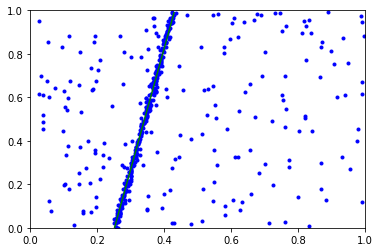

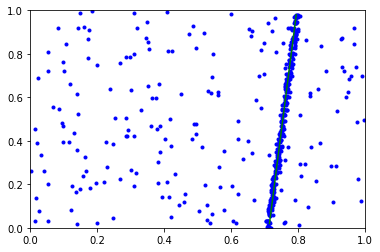

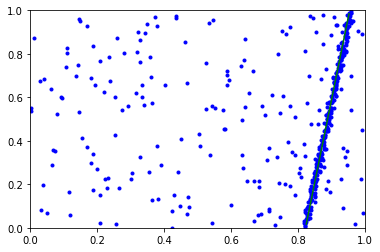

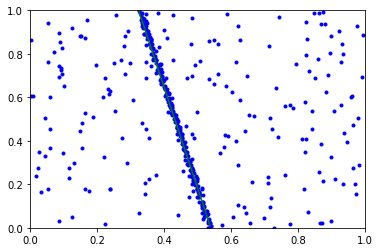

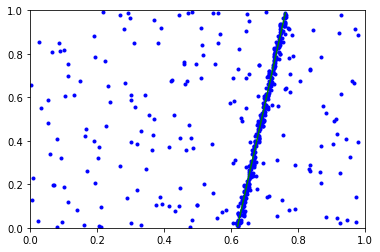

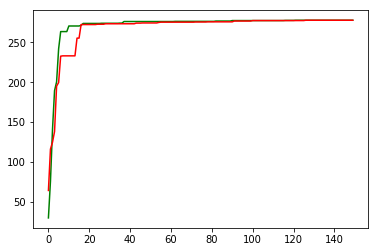

In [51]:
compare_uniform(image_size, sigma_noise, nbr_inliers, nbr_outliers, 2, model=model, model_type=1, average=5)

0
1
2
3
4
done


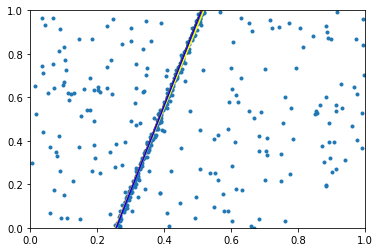

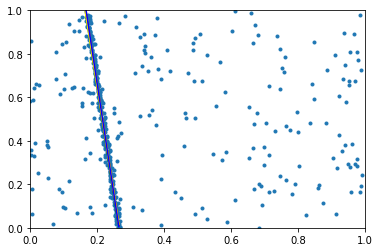

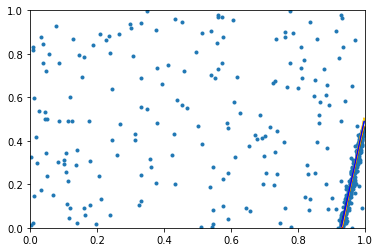

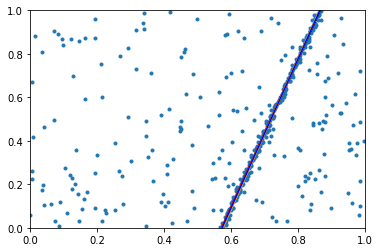

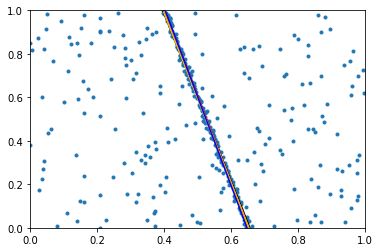

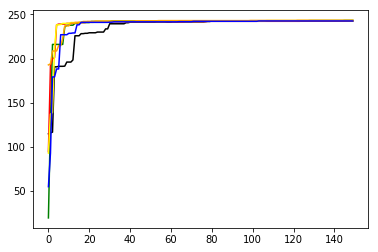

In [52]:
all_models = [(None, None, 1, 0, True), (model_old_loss, 1, 1, 0, False), (None, None, 2, 0, True), (model, 1, 2, 0, False), (model_patch, 2, 2, 0, False)]
compare_all_ransac(image_size, sigma_noise, all_models, nbr_inliers, nbr_outliers, average=5)

0
1
2
3
4
done


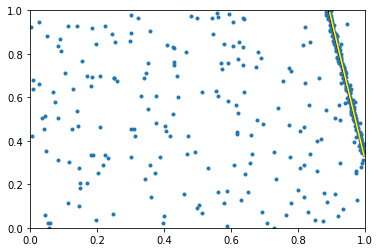

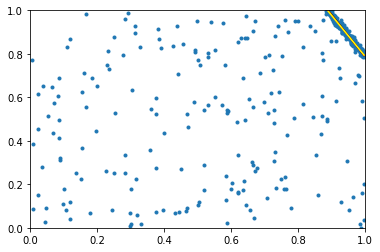

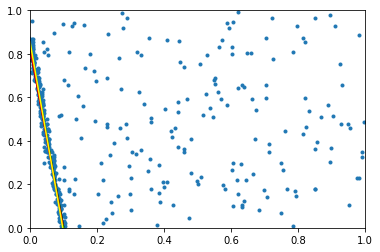

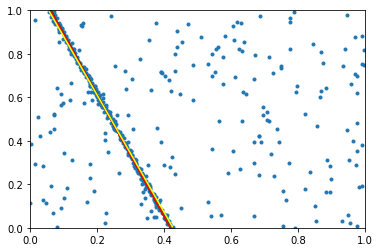

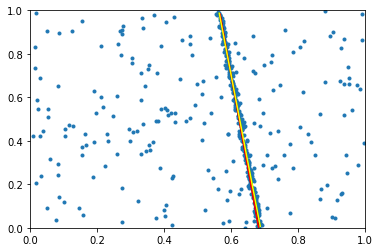

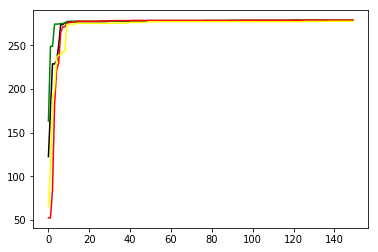

In [59]:
all_models = [(model_old_loss, 1, 1, 0, False), (model, 1, 2, 0, False), (model_patch, 2, 2, 0, False)]
compare_all_ransac(image_size, sigma_noise, all_models, nbr_inliers, nbr_outliers, average=5)

In [ ]:
all_models = [(model, 1, 2, 0, False), (model, 1, 2, 1, False)]
compare_all_ransac(image_size, sigma_noise, all_models, nbr_inliers, nbr_outliers, average=5)

0
1


#### 1st point : density + weights

In [53]:


def get_model3(model, type_model, data, image, densities, last_weights):
    n = len(data[0])
    
    threshold = 0.9
    if last_weights is not None and mean_weights(last_weights) >= threshold:
        i1 = sample_from_weights(data, last_weights)
    else:
        i1 = sample_from_weights(data, densities)
    i1 = np.random.randint(n)    
    weights = compute_weights(model, type_model, data, i1, image)
    #print(mean_weights(weights))
    i2 = sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line, weights


def ransac3(data, threshold, image, proba, model, type_model, n_x, n_y, compare=False, it_end=150):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    densities = get_density_vector(data, image, n_x, n_y)
    previous_weights = None
    while not end:
        line, previous_weights = get_model3(model, type_model, data, image, densities, previous_weights)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

In [ ]:
#Test to set threshold

line = generate_line(image_size)
data = generate_data(line, image_size, sigma_noise, nbr_inliers, nbr_outliers)
threshold = 5
proba = 0.1
ransac3(data, threshold, image_size, proba, model, 1, n_x=0.05, n_y=0.05, compare=True)

## 2 Lines

#### Uniform

In [54]:
def stopping_criterion_multi(step, inliers, total, proba):
    if step < 5000:
        return False
    
    end = True
    for n_inliers in inliers:
        x = 1 - (n_inliers/total)**2
        if x**step > proba:
            end = False
    return end

def ransac_uniform_multi(data, threshold, threshold_nbr_inliers, threshold_intersection, image, proba):
    step = 0
    inliers_max = []
    nbr_inliers_max = []
    line_max = []
    end = False
    nbr_inliers = []
    n = len(data[0])
    counter = 0
    
    while not end:
        if (step % 1000 == 0):
            print("step = ", step)
            print("counter = ", counter)
        line = get_model_uniform(data, image)
        inliers = get_inliers_couple(data, line, threshold, image)
        if len(inliers) > threshold_nbr_inliers:
            counter += 1
            max_inter = -1
            max_inliers_inter = threshold_intersection - 1
            for k in range(len(inliers_max)):
                inter = nbr_intersection(inliers, inliers_max[k])
                #print("intersection = ", inter)
                if inter > max_inliers_inter:
                    #print(len(inliers), len(inliers_max[k]))
                    #print(sorted(inliers))
                    #print()
                    #print(sorted(inliers_max[k]))
                    max_inliers_inter = inter
                    max_inter = k
                    
            if max_inter == -1:
                print("new line")
                line_max.append(line)
                inliers_max.append(inliers)
                nbr_inliers_max.append(len(inliers))
            else:
                #print("change line", max_inter, ",", "intersection =", max_inliers_inter)
                if len(inliers) > nbr_inliers_max[max_inter]:
                    line_max[max_inter] = line
                    inliers_max[max_inter] = inliers
                    nbr_inliers_max[max_inter] = len(inliers)

        step += 1
        end = stopping_criterion_multi(step, nbr_inliers_max, n, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max, inliers_max, nbr_inliers_max

In [31]:
#image_size = (200, 200)
#n_inliers = 250
#n_outliers = 400
#sigma_noise = (2, 2)

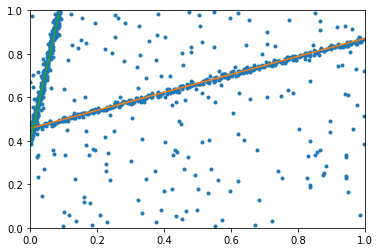

In [55]:
line1 = generate_line(image_size)
line2 = generate_line(image_size)
data = generate_data_multi_line([line1, line2], image_size, sigma_noise, nbr_inliers, nbr_outliers)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plot_data(data, ax)
plot_line(line1, image_size, ax)
plot_line(line2, image_size, ax)
fig.show()

step =  0
counter =  0
new line
new line
step =  1000
counter =  295
step =  2000
counter =  558
step =  3000
counter =  853
step =  4000
counter =  1135
nbr_lines =  2


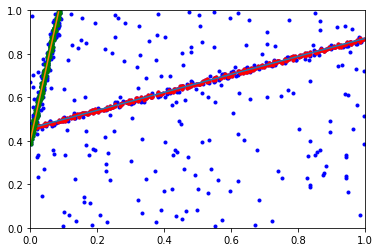

In [56]:
proba = 0.05
threshold = 2.5
threshold_nbr_inliers = 100
threshold_intersection = 20

lines_pred, inliers_pred, nbr_inliers_pred = ransac_uniform_multi(data, threshold, threshold_nbr_inliers, threshold_intersection, image_size, proba)
print("nbr_lines = ", len(lines_pred))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plot_data(data, ax, c='b')
colors = ['r', 'g', 'b']
for i in range(len(inliers_pred)):
    plot_data(change_format(inliers_pred[i]), ax, c=colors[i % 3])
    plot_line(lines_pred[i], image_size, ax)



fig.show()

#### Improved Ransac

In [57]:
def ransac_multi_improved(data, threshold, threshold_nbr_inliers, threshold_intersection, image, proba, type_first_point, type_loss, model_type = None, line_ref=None, model=None, compare=False, it_end=150, n_x=0.05, n_y=0.05):
    step = 0
    inliers_max = []
    nbr_inliers_max = []
    line_max = []
    end = False
    nbr_inliers = []
    n = len(data[0])
    counter = 0
    
    densities = get_density_vector(data, image, n_x, n_y)
    while not end:
        if (step % 10 == 0):
            print("step = ", step)
            print("counter = ", counter)
        line = get_model(model, model_type, data, image, type_loss, type_first_point, line_ref, densities)
        inliers = get_inliers_couple(data, line, threshold, image)
        print(len(inliers))
        if len(inliers) > threshold_nbr_inliers:
            counter += 1
            max_inter = -1
            max_inliers_inter = threshold_intersection*len(inliers) - 1
            for k in range(len(inliers_max)):
                inter = nbr_intersection(inliers, inliers_max[k])
                #print("intersection = ", inter)
                if inter > max_inliers_inter:
                    #print(len(inliers), len(inliers_max[k]))
                    #print(sorted(inliers))
                    #print()
                    #print(sorted(inliers_max[k]))
                    max_inliers_inter = inter
                    max_inter = k
                    
            if max_inter == -1:
                print("new line")
                line_max.append(line)
                inliers_max.append(inliers)
                nbr_inliers_max.append(len(inliers))
            else:
                print("change line", max_inter, ",", "intersection =", max_inliers_inter)
                if len(inliers) > nbr_inliers_max[max_inter]:
                    line_max[max_inter] = line
                    inliers_max[max_inter] = inliers
                    nbr_inliers_max[max_inter] = len(inliers)

        step += 1
        #end = stopping_criterion_multi(step, nbr_inliers_max, n, proba)
        end = (step > it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max, inliers_max, nbr_inliers_max

step =  0
counter =  0
282
new line
246
change line 0 , intersection = 174
223
change line 0 , intersection = 198
246
change line 0 , intersection = 160
32
215
change line 0 , intersection = 146
32
22
31
20
step =  10
counter =  5
27
202
change line 0 , intersection = 133
44
95
70
176
change line 0 , intersection = 119
19
174
change line 0 , intersection = 116
25
212
change line 0 , intersection = 147
step =  20
counter =  9
161
new line
49
23
138
change line 1 , intersection = 55
88
245
change line 0 , intersection = 202
172
change line 1 , intersection = 101
39
179
change line 0 , intersection = 126
232
change line 0 , intersection = 209
step =  30
counter =  15
10
18
23
23
21
105
change line 0 , intersection = 76
26
10
78
235
change line 0 , intersection = 210
step =  40
counter =  17
313
change line 0 , intersection = 237
8
48
42
67
289
change line 0 , intersection = 260
25
16
210
change line 0 , intersection = 154
58
step =  50
counter =  20
20
36
310
change line 0 , intersection 

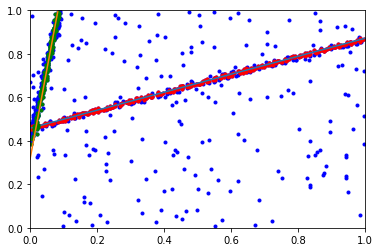

In [58]:
proba = 0.05
threshold = 2.5
threshold_nbr_inliers = 100
threshold_intersection = 0.2

lines_pred, inliers_pred, nbr_inliers_pred = ransac_multi_improved(data, threshold, threshold_nbr_inliers, threshold_intersection, image_size, proba, 0, 1, model_type=1, model=model, it_end=100)
print("nbr_lines = ", len(lines_pred))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plot_data(data, ax, c='b')
colors = ['r', 'g', 'b']
for i in range(len(inliers_pred)):
    plot_data(change_format(inliers_pred[i]), ax, c=colors[i % 3])
    plot_line(lines_pred[i], image_size, ax)



fig.show()

In [ ]:
line1 = generate_line(image_size)
line2 = generate_line(image_size)
data = generate_data_multi_line([line1, line2], image_size, sigma_noise, nbr_inliers, nbr_outliers)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plot_data(data, ax)
plot_line(line1, image_size, ax)
plot_line(line2, image_size, ax)
fig.show()